In [257]:
import numpy as np
import pandas as pd
import re
import string
from pandas import DataFrame
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import tensorflow as tf
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA, TruncatedSVD 

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
def stem(X):
    stemmer = PorterStemmer()
    stemmed_X = []

    for elem in X:
        words = elem.split()
        new_claim = [stemmer.stem(word) for word in words]
        stemmed_X.append(' '.join(new_claim))
    return np.array(stemmed_X)

# Predicting invalidation

Loading pickled data, deduplicating patents, and running model

In [8]:
ptab_patents = pd.read_pickle('ptab_patents.pkl')
all_cases = pd.read_pickle('ptab_cases.pkl')
all_info = pd.read_pickle('ptab_info.pkl')

# merigng the claims and the metadata
ptab_cases = all_cases[all_cases.denied.notnull()]
ptab_stats = ptab_cases.merge(all_info,suffixes = ["_ptab", "_patent"], on="patent_id")
ptab_stats['petitioner_name'] = ptab_stats.petitioner_name.str.lower().str.replace('[^\w\s]','')
ptab_stats['art_unit_round']= pd.Series(np.trunc(ptab_stats.art_unit.values.astype(np.float)/10.).astype(np.int)*10)
final = ptab_patents.merge(ptab_stats, suffixes = ["_algo", "_all"], on="patent_id")

# De-duplicating patents and creating dataset
data = final.dropna(axis=0, how='any')
mask = (data.claim_text.str.len() > 1)
data = data.loc[mask]
dups = data.duplicated(subset='claim_text', keep='first')
data = data.loc[~dups]
X = data.claim_text.as_matrix()
data['art_unit_round'] = data.art_unit_round.apply(str)
meta_X_all = pd.get_dummies(data[['petitioner_name', 'art_unit', 'examiner_name']]).as_matrix()
meta_X_all2 = pd.get_dummies(data[['petitioner_name', 'art_unit_round', 'examiner_name']]).as_matrix()
meta_X_pet_art = pd.get_dummies(data[['petitioner_name', 'art_unit']]).as_matrix()
meta_X_pet_art2 = pd.get_dummies(data[['petitioner_name', 'art_unit_round']]).as_matrix()
meta_X_art2 = pd.get_dummies(data[['art_unit_round']]).as_matrix()
meta_X_art = pd.get_dummies(data[['art_unit']]).as_matrix()
y = data.invalidated_all.as_matrix()

In [11]:
new_X = stem(X) 

In [376]:
from scipy.sparse import hstack

def transform_text(X, meta, y, n=(1, 1)):
    split_ratio = 0.2
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X, y, test_size=split_ratio, random_state=20)
    
    tfidf = TfidfVectorizer(ngram_range=n)
    tfidf.fit(X)
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)

    if meta != None:
        meta_train, meta_test, y_meta_train, y_meta_test = cross_validation.train_test_split(
            meta, y, test_size=split_ratio, random_state=20)  
        meta_X_train = hstack((X_train, meta_train[:,:]))
        meta_X_test = hstack((X_test, meta_test[:,:]))
    else:
        meta_X_train = X_train
        meta_X_test = X_test
        
    return meta_X_train, y_train, meta_X_test, y_test, tfidf

def train_model(X_train, y_train, X_test, y_test, classifier, silent=True):
      # logistic_class = LogisticRegressionCV(Cs=np.arange(0.1, 5, 0.1), penalty='l2', dual=False, random_state=15, cv=5)
    # model = logistic_class.fit(meta_X_train, y_train)
    model = classifier.fit(X_train, y_train)
    
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    
    if not silent:
        print('Shape of the matrix is {}'.format(X_train.shape))
        print("Training accuracy is {0}".format(model.score(X_train, y_train)))
        print("Testing accuracy is {0}".format(model.score(X_test, y_test)))
        print("Precision is {0}".format(precision))
        print("Recall is {0}".format(recall))
    
    return model, model.score(X_test, y_test)

In [385]:
classifier = LinearSVC(random_state=20)
train_model(X_train, y_train, X_test, y_test, classifier, False)
train_model(X_train_stemmed, y_train, X_test_stemmed, y_test, classifier, False)
train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier, False)
train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier, False)

Shape of the matrix is (1264, 14249)
Training accuracy is 0.9825949367088608
Testing accuracy is 0.7160883280757098
Precision is 0.6274509803921569
Recall is 0.5517241379310345
Shape of the matrix is (1264, 12588)
Training accuracy is 0.9723101265822784
Testing accuracy is 0.722397476340694
Precision is 0.6428571428571429
Recall is 0.5431034482758621
Shape of the matrix is (1264, 12989)
Training accuracy is 0.9841772151898734
Testing accuracy is 0.6782334384858044
Precision is 0.5603448275862069
Recall is 0.5603448275862069
Shape of the matrix is (1264, 13690)
Training accuracy is 0.995253164556962
Testing accuracy is 0.7444794952681388
Precision is 0.6732673267326733
Recall is 0.5862068965517241


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
      verbose=0), 0.74447949526813884)

In [13]:
score = {'log': {}, 'svc': {}, 'rf': {}}
score_pca = []
score_bi = []
score_svc = []

score['log']['stemmed'] = []
score['log']['normal'] = []
score['log']['art_unit'] = []
score['log']['all'] = []

print('LOG')
name = 'log'

X_train, y_train, X_test, y_test = transform_text(X, None, y)
X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed = transform_text(new_X, None, y)
X_train_art, y_train_art, X_test_art, y_test_art = transform_text(new_X, meta_X_art, y)
X_train_all, y_train_all, X_test_all, y_test_all = transform_text(new_X, meta_X_pet_art, y)

for C in np.arange(0.1, 5, 0.1):
    print(C)
    classifier = LogisticRegression(C=C, penalty='l2', dual=True, random_state=15)
    model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier)
    score[name]['normal'].append(accuracy)
    
    model, accuracy = train_model(X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, classifier)
    score[name]['stemmed'].append(accuracy)
    
    model, accuracy = train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier)
    score[name]['art_unit'].append(accuracy)
    
    model, accuracy = train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier)
    score[name]['all'].append(accuracy)

LOG


C:\Users\Dany\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.1


C:\Users\Dany\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


In [182]:
bi_X_train, y_train, bi_X_test, y_test = transform_text(X, None, y, (1,2))
bi_X_train_stemmed, y_train_stemmed, bi_X_test_stemmed, y_test_stemmed = transform_text(new_X, None, y, (1, 2))
# bi_X_train_art, y_train_art, bi_X_test_art, y_test_art = transform_text(new_X, meta_X_art, y, (1, 2))
# bi_X_train_all, y_train_all, bi_X_test_all, y_test_all = transform_text(new_X, meta_X_pet_art, y, (1, 2))

In [195]:
tri_X_train_stemmed, y_train_stemmed, tri_X_test_stemmed, y_test_stemmed = transform_text(new_X, None, y, (1, 3))
tri_X_train_stemmed

<1264x441060 sparse matrix of type '<class 'numpy.float64'>'
	with 776600 stored elements in Compressed Sparse Row format>

In [200]:
quad_X_train_stemmed, y_train_stemmed, quad_X_test_stemmed, quad_test_stemmed = transform_text(new_X, None, y, (1, 4))

In [201]:
quad_X_train_stemmed

<1264x871033 sparse matrix of type '<class 'numpy.float64'>'
	with 1215835 stored elements in Compressed Sparse Row format>

In [234]:
tri_X_train_stemmed, y_train_stemmed, tri_X_test_stemmed, y_test_stemmed = transform_text(new_X, meta_X_art, y, (1, 3))

C:\Users\Dany\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [235]:
tri_X_train_stemmed

<1264x441461 sparse matrix of type '<class 'numpy.float64'>'
	with 777864 stored elements in COOrdinate format>

In [236]:
score_svc_stem_art_quad = []
score_svc_stem_art_tri = []
score_svc_stem_art_bi = []

# bi_X_train_stemmed, y_train_stemmed, bi_X_test_stemmed, y_test_stemmed = transform_text(new_X, meta_X_art, y, (1, 2))

quad_X_train_stemmed, y_train_stemmed, quad_X_test_stemmed, quad_test_stemmed = transform_text(new_X, meta_X_art, y, (1, 4))
# score_svc_stem_quad = []

for C in np.arange(0.1, 10, 0.1):
    print(C)
    classifier = LinearSVC(C=C)
    model, accuracy = train_model(quad_X_train_stemmed, y_train, quad_X_test_stemmed, y_test, classifier)
    score_svc_stem_art_quad.append(accuracy)
    
    model, accuracy = train_model(bi_X_train_stemmed, y_train, bi_X_test_stemmed, y_test, classifier)
    score_svc_stem_art_bi.append(accuracy)
    
    model, accuracy = train_model(tri_X_train_stemmed, y_train, tri_X_test_stemmed, y_test, classifier)
    score_svc_stem_art_tri.append(accuracy)
    
    

C:\Users\Dany\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9


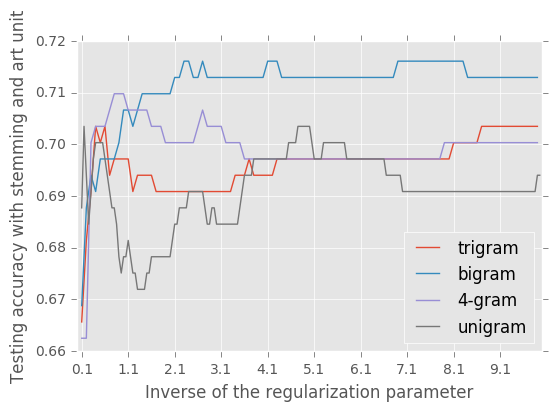

In [238]:
plt.plot(np.arange(0.1, 10, 0.1), score_svc_stem_art_tri, label='trigram')
plt.plot(np.arange(0.1, 10, 0.1), score_svc_stem_art_bi, label='bigram')
plt.plot(np.arange(0.1, 10, 0.1), score_svc_stem_art_quad, label='4-gram')
plt.plot(np.arange(0.1, 10, 0.05), score['svc']['art_unit'], label='unigram')
plt.legend(loc=4, fontsize=12)
plt.xticks(np.arange(0.1, 10, 1))
plt.xlabel('Inverse of the regularization parameter')
plt.ylabel('Testing accuracy with stemming and art unit')

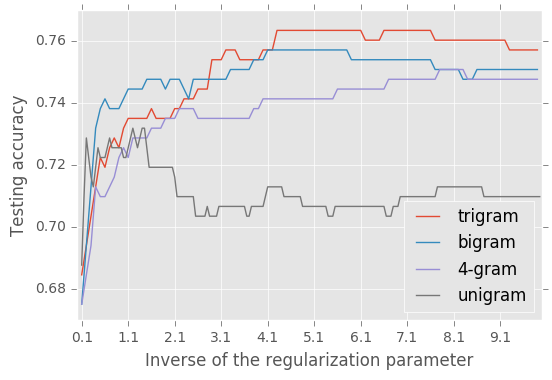

In [227]:
plt.plot(np.arange(0.1, 10, 0.1), score_svc_stem_tri, label='trigram')
plt.plot(np.arange(0.1, 10, 0.1), score_svc_stem, label='bigram')
plt.plot(np.arange(0.1, 10, 0.1), score_svc_stem_quad, label='4-gram')
plt.plot(np.arange(0.1, 10, 0.05), score['svc']['stemmed'], label='unigram')
plt.legend(loc=4, fontsize=12)
plt.xticks(np.arange(0.1, 10, 1))
plt.xlabel('Inverse of the regularization parameter')
plt.ylabel('Testing accuracy')

In [314]:
np.arange(0.1, 10, 0.1)[np.argmax(score_svc_stem_tri)]

4.2999999999999998

In [272]:
score_log_stem_quad = []
score_log_stem_tri = []
score_log_stem_bi = []
score_log_stem_uni = []

bi_X_train_stemmed, y_train_stemmed, bi_X_test_stemmed, y_test_stemmed = transform_text(new_X, None, y, (1, 2))
tri_X_train_stemmed, y_train_stemmed, tri_X_test_stemmed, y_test_stemmed = transform_text(new_X, None, y, (1, 3))
quad_X_train_stemmed, y_train_stemmed, quad_X_test_stemmed, quad_test_stemmed = transform_text(new_X, None, y, (1, 4))
# score_svc_stem_quad = []

for C in np.arange(0.1, 10, 0.2):
    print(C)
    classifier = LogisticRegression(C=C, penalty='l2', dual=True, random_state=15)
    model, accuracy = train_model(quad_X_train_stemmed, y_train, quad_X_test_stemmed, y_test, classifier)
    score_log_stem_quad.append(accuracy)
    
    model, accuracy = train_model(bi_X_train_stemmed, y_train, bi_X_test_stemmed, y_test, classifier)
    score_log_stem_bi.append(accuracy)
    
    model, accuracy = train_model(tri_X_train_stemmed, y_train, tri_X_test_stemmed, y_test, classifier)
    score_log_stem_tri.append(accuracy)    
    
    model, accuracy = train_model(X_train_stemmed, y_train, X_test_stemmed, y_test, classifier)
    score_log_stem_uni.append(accuracy)    

0.1


C:\Users\Dany\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3
0.5
0.7
0.9
1.1
1.3
1.5
1.7
1.9
2.1
2.3
2.5
2.7
2.9
3.1
3.3
3.5
3.7
3.9
4.1
4.3
4.5
4.7
4.9
5.1
5.3
5.5
5.7
5.9
6.1
6.3
6.5
6.7
6.9
7.1
7.3
7.5
7.7
7.9
8.1
8.3
8.5
8.7
8.9
9.1
9.3
9.5
9.7
9.9


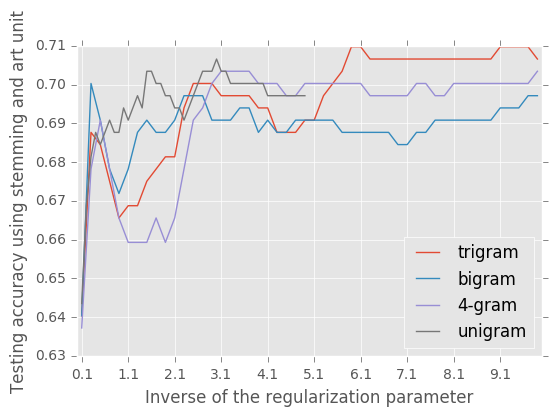

In [273]:
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_art_tri, label='trigram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_art_bi, label='bigram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_art_quad, label='4-gram')
plt.plot(np.arange(0.1, 5, 0.1), score['log']['art_unit'], label='unigram')
plt.legend(loc=4, fontsize=12)
plt.xticks(np.arange(0.1, 10, 1))
plt.xlabel('Inverse of the regularization parameter')
plt.ylabel('Testing accuracy using stemming and art unit')

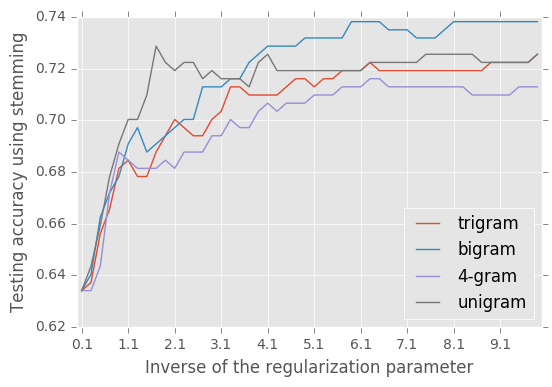

In [274]:
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_tri, label='trigram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_bi, label='bigram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_quad, label='4-gram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_stem_uni, label='unigram')
plt.legend(loc=4, fontsize=12)
plt.xticks(np.arange(0.1, 10, 1))
plt.xlabel('Inverse of the regularization parameter')
plt.ylabel('Testing accuracy using stemming')

In [18]:
score['svc']['stemmed'] = []
score['svc']['normal'] = []
score['svc']['art_unit'] = []
score['svc']['all'] = []
print('SVC')
name = 'svc'
for C in np.arange(0.1, 10, 0.05):
    if (C % 1) == 0:
        print(C)
    classifier = LinearSVC(C=C)
    model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier)
    score[name]['normal'].append(accuracy)

    model, accuracy = train_model(X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, classifier)
    score[name]['stemmed'].append(accuracy)

    model, accuracy = train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier)
    score[name]['art_unit'].append(accuracy)

    model, accuracy = train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier)
    score[name]['all'].append(accuracy)

SVC


In [249]:
np.max(score_svc_stem_tri)
np.arange(0.1, 10, 0.1)[np.argmax(score_svc_stem_tri)]

4.2999999999999998

In [378]:
# rf is for 100 and 10 min leaf
# rf2 is for 100 and max depth 36 np.arange(1, 20, 1)
# rf3 is for 100 and min 1 np.arange(10, 40, 2):

score['rf3'] = {}
score['rf3']['stemmed'] = []
score['rf3']['normal'] = []
score['rf3']['art_unit'] = []
score['rf3']['all'] = []
print('RF')
name = 'rf3'
for C in np.arange(10, 40, 2):
    print(C)
    classifier = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=1,
                                              max_depth=C,
                                       random_state=30)
    model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier)
    score[name]['normal'].append(accuracy)

    model, accuracy = train_model(X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, classifier)
    score[name]['stemmed'].append(accuracy)

    model, accuracy = train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier)
    score[name]['art_unit'].append(accuracy)

    model, accuracy = train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier)
    score[name]['all'].append(accuracy)

RF
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38


In [388]:
np.argmax(score['log']['all'])

20

In [368]:
classifier = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=1,
                                              max_depth=32, random_state=30)
model, accuracy = train_model(X_train_stemmed, y_train, X_test_stemmed, y_test_art, classifier)
accuracy

0.69085173501577291

In [369]:
np.argsort(model.feature_importances_)[-10:]
list_word = []
for feature in np.argsort(model.feature_importances_)[-10:]:
    for word in tfidf.vocabulary_:
        if tfidf.vocabulary_[word] == feature:
            list_word.append(word)

model.feature_importances_ 

array([  0.00000000e+00,   1.31650523e-04,   0.00000000e+00, ...,
         0.00000000e+00,   0.00000000e+00,   2.91014402e-05])

In [370]:
list_word

['sourc',
 'compris',
 'use',
 'method',
 'th',
 'text',
 'posit',
 'comprising',
 'instruct',
 'device']

In [371]:
np.argsort(model.feature_importances_)[-10:]

array([10423,  2699, 11844,  6959, 11201, 11193,  8675,  2706,  5985,  3469], dtype=int64)

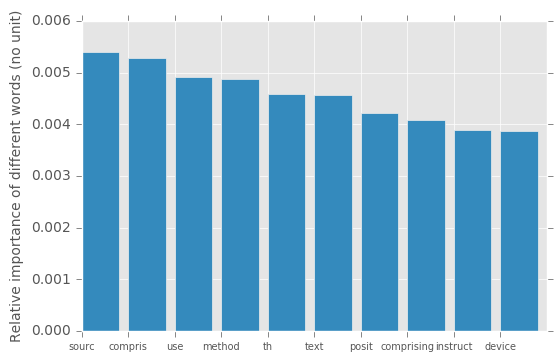

In [375]:
plt.bar(range(10), np.sort(model.feature_importances_)[-10:][::-1])
plt.xticks(range(10), list_word, fontsize=7)
plt.ylabel('Relative importance of different words (no unit)', fontsize=10)

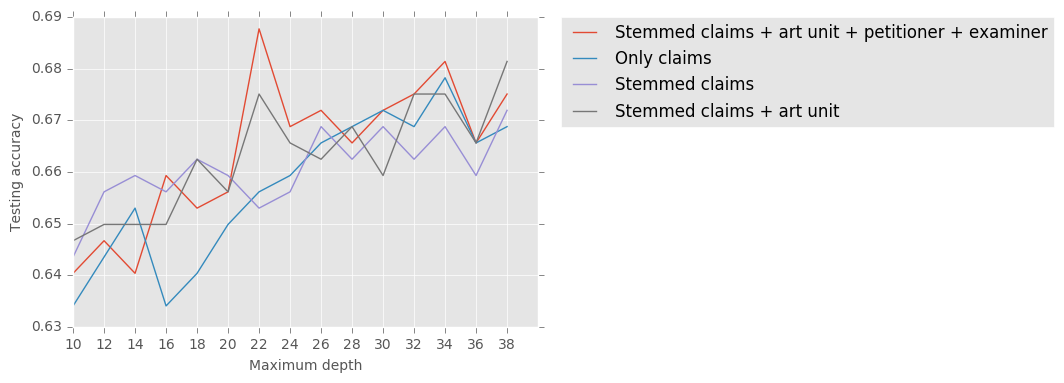

In [389]:
name = 'rf3'
xrange = np.arange(10, 40, 2)
np.arange(1, 20, 1)
plt.plot(xrange, score[name]['all'], label='Stemmed claims + art unit + petitioner + examiner')
plt.plot(xrange, score[name]['normal'], label='Only claims')
plt.plot(xrange, score[name]['stemmed'], label='Stemmed claims')
plt.plot(xrange, score[name]['art_unit'], label='Stemmed claims + art unit')
plt.xticks(np.arange(10, 40, 2))
plt.yticks(fontsize=10)
plt.xlabel('Maximum depth', fontsize=10)
plt.ylabel('Testing accuracy', fontsize=10)
# plt.title('Testing accuracy for a random forest of 100 trees depending on the minimum number of  (max depth=36)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

In [391]:
np.max(score[name]['all'])

0.68769716088328081

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(new_X)
tfidf_x_stemmed = tfidf.transform(new_X)

In [309]:
tri_X_train_stemmed

<1264x441060 sparse matrix of type '<class 'numpy.float64'>'
	with 776600 stored elements in Compressed Sparse Row format>

In [277]:
pca_score_svc_quad = []

tfidf = TfidfVectorizer(ngram_range=(1, 3))
tfidf.fit(new_X)
tfidf_x_stemmed = tfidf.transform(new_X)

for n in range(2, 100, 5):
    svd  = TruncatedSVD (n_components=n)
    svd.fit(tfidf_x_stemmed)
    svd_stemmed_train = svd.transform(tri_X_train_stemmed)
    svd_stemmed_test = svd.transform(tri_X_test_stemmed)
    
    classifier = LinearSVC(C=4.3)
    model, accuracy = train_model(svd_stemmed_train, y_train, svd_stemmed_test, y_test, classifier)
    pca_score_svc_quad.append(accuracy)
    print(accuracy)

0.627760252366
0.637223974763
0.621451104101
0.608832807571
0.627760252366
0.627760252366
0.608832807571
0.611987381703
0.599369085174
0.615141955836
0.630914826498
0.615141955836
0.634069400631
0.611987381703
0.643533123028
0.646687697161
0.608832807571
0.659305993691
0.637223974763
0.634069400631


In [288]:
# tfidf = TfidfVectorizer()
# tfidf.fit(new_X)
# tfidf_x_stemmed = tfidf.transform(new_X)
pca  = PCA(n_components=1000)
pca.fit(tfidf_x_stemmed.toarray())
pca_stemmed_train = pca.transform(X_train_stemmed.toarray())
pca_stemmed_test = pca.transform(X_test_stemmed.toarray())

classifier = LinearSVC(C=1.7)
model, accuracy = train_model(pca_stemmed_train, y_train, pca_stemmed_test, y_test, classifier)
print(accuracy)

0.719242902208


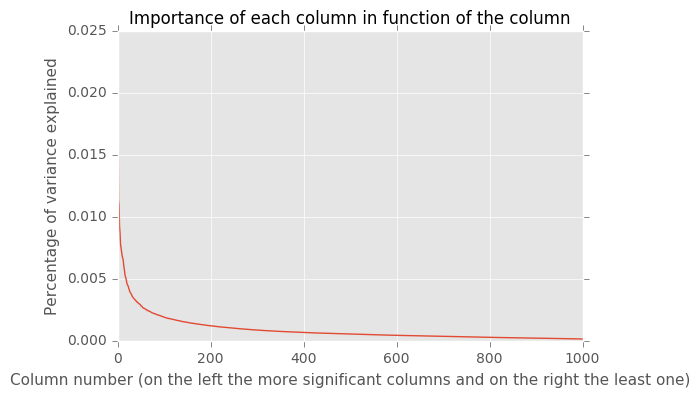

In [301]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Percentage of variance explained', fontsize=11)
plt.xlabel('Column number (on the left the more significant columns and on the right the least one)', fontsize=11)
plt.title('Importance of each column in function of the column', fontsize=12)

In [ ]:
for n in range(1000, 139000, 1000):
    pca = PCA(n_components=n)
    pca.fit(tfidf_x_stemmed)
    pca_stemmed_train = pca.transform(tri_X_train_stemmed.toarray())
    pca_stemmed_test = pca.transform(tri_X_test_stemmed.toarray())
    
    classifier = LinearSVC(C=4.3)
    model, accuracy = train_model(pca_stemmed_train, y_train, pca_stemmed_test, y_test, classifier)
    pca_score_svc_quad.append(accuracy)
    print(accuracy)

In [ ]:
classifier = LinearSVC(C=C)

In [174]:
pca_score_log2 = []

for n in range(5000, 12000, 1000):
    print(n)
    pca = PCA(n_components=n)
    pca.fit(tfidf_x_stemmed.toarray())
    pca_stemmed_train = pca.transform(X_train_stemmed.toarray())
    pca_stemmed_test = pca.transform(X_test_stemmed.toarray())
    
    classifier = LogisticRegression(C=1.7, penalty='l2', dual=True, random_state=15)
    model, accuracy = train_model(pca_stemmed_train, y_train, pca_stemmed_test, y_test, classifier)
    pca_score_log2.append(accuracy)

5000
6000
7000
8000
9000
10000
11000


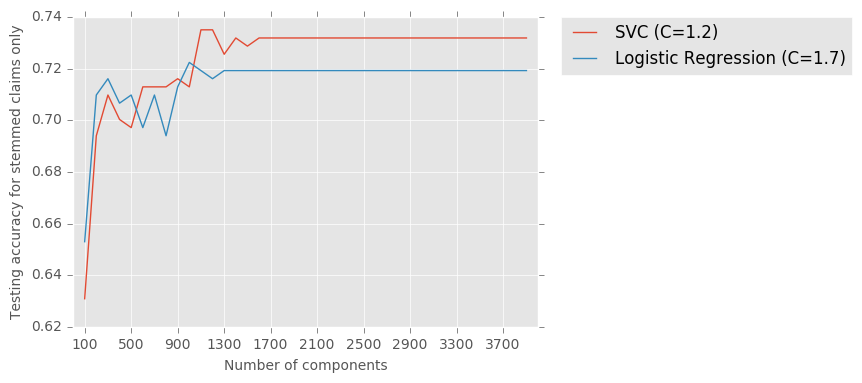

In [302]:
plt.plot(range(100, 4000, 100), pca_score_svc[-39:], label='SVC (C=1.2)')
plt.plot(range(100, 4000, 100), pca_score_log, label='Logistic Regression (C=1.7)')
plt.xticks(range(100, 4000, 400))
plt.yticks(fontsize=10)
plt.xlabel('Number of components', fontsize=10)
plt.ylabel('Testing accuracy for stemmed claims only', fontsize=10)
# plt.title('Testing accuracy for a random forest of 100 trees depending on the minimum number of  (max depth=36)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
#plt.plot(pca_score_svc[-39:])

In [306]:
np.max(pca_score_svc[-39:])
np.max(pca_score_log)

0.72239747634069396

In [282]:
range(100, 4000, 100)[np.argmax(pca_score_log)]

1000

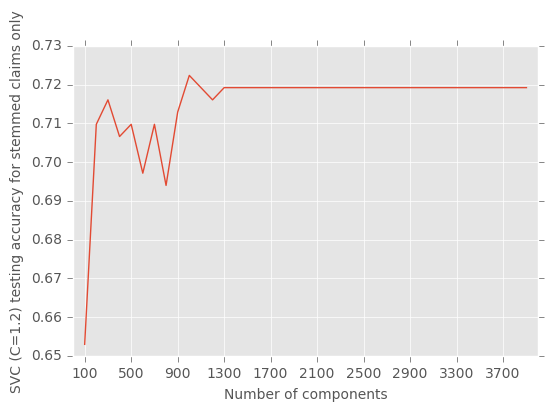

In [171]:
plt.plot(range(100, 4000, 100), pca_score_log)
plt.xticks(range(100, 4000, 400))
plt.yticks(fontsize=10)
plt.xlabel('Number of components', fontsize=10)
plt.ylabel('SVC (C=1.2) testing accuracy for stemmed claims only', fontsize=10)

In [147]:
np.argmax(score['svc']['stemmed'])
np.arange(0.1, 10, 0.05)[22]

1.2000000000000004

In [173]:
np.max(score['log']['stemmed'])

0.72870662460567825

In [62]:
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
# Simple function to prettify axes
# E.g.:
# ax = plt.subplot(111)
# simpleaxis(ax)
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

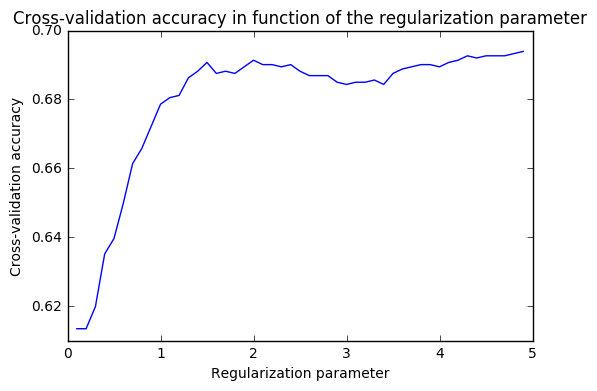

In [169]:
plt.plot(model.Cs_, np.mean(model.scores_[1.], axis=0))
plt.xlabel('Regularization parameter')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation accuracy in function of the regularization parameter')

In [ ]:
split_ratio = 0.2
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=split_ratio, random_state=20)

tfidf = TfidfVectorizer()
tfidf.fit(X)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)


In [12]:
import pickle
f = open('invalidation_model.pkl', 'wb')
pickle.dump(model3, open('invalidation_model.pkl', 'wb'))
pickle.dump(tf, open('invalidation_tfidf.pkl', 'wb'))
f.close()

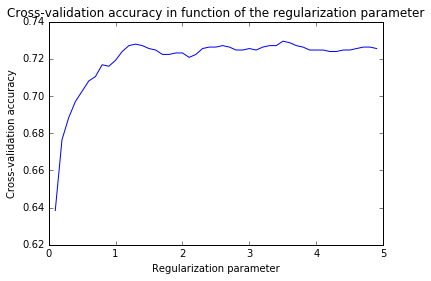

In [382]:
plt.plot(model.Cs_, np.mean(model.scores_[1.], axis=0))
plt.xlabel('Regularization parameter')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation accuracy in function of the regularization parameter')

In [371]:
model.Cs_[np.argmax(np.mean(model.scores_[1.], axis=0))]

3.5000000000000004

Recall is high when we keep our false negatives low and precision is high when we keep our false positives low. Basically, this classifier is overindexing on precision relative to recall. A next step here would be to look at tradeoffs between precision and recall between different probabalistic classifiers. We probably also want to play with regularization.

In [388]:
# only works when with random forest
np.argsort(model3.feature_importances_)[-10:]
for feature in np.argsort(model3.feature_importances_)[-10:]:
    for word in tf.vocabulary_:
        if tf.vocabulary_[word] == feature:
            print word

or
correspond
of
from
plural
user
to
comprising
provid
the


In [403]:
np.sort(model3.feature_importances_)

array([ 0.        ,  0.        ,  0.        , ...,  0.00830895,
        0.00844366,  0.00854598])

# Neural Network

In [24]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    new_X, y, test_size=0.2, random_state=20)

tfidf = TfidfVectorizer()
tfidf.fit(new_X)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [66]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 12677])
y_ = tf.placeholder(tf.float32, shape=[None, 2])
                   
W_h = tf.Variable(tf.zeros([X_train.shape[1], 2000]))
b_h = tf.Variable(tf.zeros([2000]))

h = tf.nn.softmax(tf.matmul(x, W_h) + b_h)

W_o = tf.Variable(tf.zeros([2000, 2]))
b_o = tf.Variable(tf.zeros([2]))

y = tf.nn.softmax(tf.matmul(h, W_o) + b_o)
y_ = tf.placeholder(tf.float32, [None, 2])

# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [72]:
tf.global_variables_initializer().run()

for _ in range(300):
    print(_)
    batch_xs, batch_ys = X_train.toarray(), np.vstack((np.abs(y_train - 1), y_train)).T
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: X_test.toarray(), y_: np.vstack((np.abs(y_test - 1), y_test)).T}))

0.606811


In [71]:
print(x.get_shape())

(?, 12677)
